## Importing Necessary Libraries

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import nltk
nltk.download('words')
from nltk import pos_tag
from nltk.corpus import words
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet 

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error

from scipy.spatial.distance import cdist
from scipy.sparse import hstack, csr_matrix, coo_matrix, csc_matrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import clone_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Embedding, Flatten, Dropout, Concatenate, BatchNormalization, Reshape, Lambda, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Bidirectional

import keras_tuner as kt
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import SimpleRNN, Dense, Dropout, Input, concatenate

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\kavik\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kavik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kavik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kavik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kavik\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Loading the Dataset 

In [2]:
# loading my dataset into a DataFrame
df = pd.read_csv(r'C:\Users\kavik\Downloads\fypMLDataset\LinkedInJobs_MLDataset.csv')

## Data Cleaning

#### Removing Duplicates, Dropping Unnecessary Columns, and Handling Missing Values

In [3]:
# dropping duplicates
df_cleaned = df.drop_duplicates()

# defining columns not necessary 
columns_to_drop = [
    'Co_Nm', 'Co_Pg_Lstd', 'Flw_Cnt', 'max_sal', 'min_sal', 'Is_Supvsr',
    'py_prd', 'loc', 'st_code', 'is_remote', 'views', 'app_typ',
    'app_is_off', 'xp_lvl', 'domain', 'has_post_domain', 'is_sponsored', 'base_comp','py_lstd'
]

# dropping columns not necessary 
df_cleaned = df.drop(columns=columns_to_drop)

# dropping rows with null values
df_cleaned.dropna(inplace=True)

# size of the df
print(f"Size of cleaned DataFrame: {df_cleaned.shape}")

# df
print(df_cleaned.head())


Size of cleaned DataFrame: (33244, 5)
   Emp_Cnt                                            Job_Ttl  \
0     1171                              Hearing Care Provider   
1      300  Shipping & Receiving Associate 2nd shift (Beav...   
2      314                               Manager, Engineering   
3       36                                               Cook   
4     1227        Principal Cloud Security Architect (Remote)   

                                            Job_Desc    med_sal    wrk_typ  
0  Overview\n\nHearingLife is a national hearing ...    5250.00  Full-time  
1  Metalcraft of Mayville\nMetalcraft of Mayville...       0.00  Full-time  
2  The TSUBAKI name is synonymous with excellence...       0.00  Full-time  
3  descriptionTitle\n\n Looking for a great oppor...      22.27  Full-time  
4  Job Summary\nAt iHerb, we are on a mission to ...  240895.00  Full-time  


## Reframing my data

#### Mapping Job Titles

In [4]:
# finding unique titles
unique_job_titles = df_cleaned['Job_Ttl'].unique()

# converting to a list 
unique_job_titles_list = unique_job_titles.tolist()

print(f"Number of unique job titles: {len(unique_job_titles_list)}")

Number of unique job titles: 22288


In [5]:
# tokenize job titles
def tokenize(text):
    # Lowercase and remove non-alphabetic characters
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

# applying tokenization to all job titles
all_titles = df_cleaned['Job_Ttl'].dropna()
all_tokens = []
for title in all_titles:
    all_tokens.extend(tokenize(title))

# counting the frequency of each word
word_counts = Counter(all_tokens)

# getting the most common words
most_common_words = word_counts.most_common(20)  # Adjust the number as needed

# displaying the most common words
print("Most common words in job titles:")
for word, count in most_common_words:
    print(f"{word}: {count}")

# df for viewing
df_word_counts = pd.DataFrame(most_common_words, columns=['Word', 'Count'])
print(df_word_counts)


Most common words in job titles:
manager: 5292
engineer: 2919
senior: 2296
sales: 2126
specialist: 1789
associate: 1705
assistant: 1602
director: 1568
analyst: 1562
technician: 1312
nurse: 1162
and: 1015
project: 978
rn: 926
of: 853
time: 845
business: 837
lead: 825
service: 810
coordinator: 770
           Word  Count
0       manager   5292
1      engineer   2919
2        senior   2296
3         sales   2126
4    specialist   1789
5     associate   1705
6     assistant   1602
7      director   1568
8       analyst   1562
9    technician   1312
10        nurse   1162
11          and   1015
12      project    978
13           rn    926
14           of    853
15         time    845
16     business    837
17         lead    825
18      service    810
19  coordinator    770


In [6]:
# categorize job titles
def categorize_job_titles(title):
    title = title.lower()
    if 'engineer' in title:
        return 'Engineer'
    elif 'manager' in title:
        return 'Manager'
    elif 'analyst' in title:
        return 'Analyst'
    elif 'developer' in title:
        return 'Developer'
    elif 'consultant' in title:
        return 'Consultant'
    elif 'specialist' in title:
        return 'Specialist'
    elif 'sales' in title:
        return 'Sales'
    elif 'nurse' in title:
        return 'Nursing'
    elif 'technician' in title:
        return 'Technician'
    elif 'assistant' in title:
        return 'Assistant'
    elif 'associate' in title:
        return 'Associate'
    elif 'technologist' in title:
        return 'Technologist'
    elif 'administrator' in title:
        return 'Administrator'
    elif 'senior' in title:
        return 'Senior'
    elif 'representative' in title:
        return 'Representative'
    elif 'director' in title:
        return 'Director'
    else:
        return 'Other'

# apply the categorization
df_cleaned['Job_Ttl_Categorized'] = df_cleaned['Job_Ttl'].apply(categorize_job_titles)

# checking distribution of new categories
print(df_cleaned['Job_Ttl_Categorized'].value_counts())

Other             11675
Manager            5116
Engineer           3262
Specialist         1744
Sales              1570
Analyst            1529
Technician         1259
Associate          1165
Assistant          1135
Nursing            1113
Director            941
Senior              721
Developer           688
Consultant          485
Representative      391
Administrator       290
Technologist        160
Name: Job_Ttl_Categorized, dtype: int64


## Text Preprocessing 

#### Tokenization, Lemmatization, POS Tagging, and Filtering

In [7]:
# initializw the lemmatizer
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    """Convert treebank tags to wordnet tags"""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_tokens(tokens):
    """Lemmatize tokens based on their POS tags"""
    lemmatized_tokens = []
    pos_tags = pos_tag(tokens)
    for token, tag in pos_tags:
        wordnet_tag = get_wordnet_pos(tag)
        lemmatized_token = lemmatizer.lemmatize(token, pos=wordnet_tag)
        lemmatized_tokens.append(lemmatized_token)
    return lemmatized_tokens

def normalize_and_tokenize(job_title):
    """Normalize and tokenize job title"""
    if isinstance(job_title, list):
        job_title = ' '.join(job_title)  # Join list elements into a single string
    tokens = word_tokenize(job_title.lower())
    return lemmatize_tokens(tokens)

def tokenize_and_remove_stopwords(job_desc):
    """Tokenize, remove stopwords, and lemmatize job description"""
    if isinstance(job_desc, list):
        job_desc = ' '.join(job_desc)  # Join list elements into a single string
    tokens = word_tokenize(job_desc.lower())
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return lemmatize_tokens(filtered_tokens)

def pos_tagging(tokens):
    """Apply POS tagging to tokens"""
    return pos_tag(tokens)

def filter_tokens_by_pos(tags):
    """Filter tokens based on useful POS tags"""
    useful_pos_tags = {'NN', 'JJ', 'VB'}
    return [token for token, tag in tags if tag in useful_pos_tags]

def filter_non_english_tokens(tokens):
    """Filter tokens to keep only proper English words"""
    return [token for token in tokens if token in english_words]

# loading the list of English words
english_words = set(words.words())

# applying normalization and tokenization to Job_Ttl and Job_Desc columns
df_cleaned['Job_Ttl'] = df_cleaned['Job_Ttl'].apply(normalize_and_tokenize)
df_cleaned['Job_Desc'] = df_cleaned['Job_Desc'].apply(tokenize_and_remove_stopwords)

# applying POS tagging and filter based on useful POS tags
df_cleaned['Job_Ttl'] = df_cleaned['Job_Ttl'].apply(pos_tagging).apply(filter_tokens_by_pos)
df_cleaned['Job_Desc'] = df_cleaned['Job_Desc'].apply(pos_tagging).apply(filter_tokens_by_pos)

# applying filtering for English words
df_cleaned['Job_Ttl'] = df_cleaned['Job_Ttl'].apply(filter_non_english_tokens)
df_cleaned['Job_Desc'] = df_cleaned['Job_Desc'].apply(filter_non_english_tokens)

# resetting index
df_cleaned.reset_index(drop=True, inplace=True)

# displaying updated DataFrame
print(df_cleaned.head())

   Emp_Cnt                                          Job_Ttl  \
0     1171                           [hear, care, provider]   
1      300           [ship, receive, associate, shift, dam]   
2      314                           [manager, engineering]   
3       36                                           [cook]   
4     1227  [principal, cloud, security, architect, remote]   

                                            Job_Desc    med_sal    wrk_typ  \
0  [overview, national, hearing, care, company, p...    5250.00  Full-time   
1  [metalcraft, metalcraft, equal, opportunity, e...       0.00  Full-time   
2  [name, synonymous, excellence, quality, depend...       0.00  Full-time   
3  [look, great, opportunity, professional, skill...      22.27  Full-time   
4  [job, summary, mission, health, wellness, acce...  240895.00  Full-time   

  Job_Ttl_Categorized  
0               Other  
1           Associate  
2            Engineer  
3               Other  
4               Other  


In [8]:
print("Size of cleaned dataset:", df_cleaned.shape)

Size of cleaned dataset: (33244, 6)


In [9]:
# saving in new df to avoid processing again and again
df_processed = df_cleaned.copy()

## Feature Extraction

#### TF-IDF

In [10]:
# converting token lists to strings
df_processed['Job_Ttl'] = df_processed['Job_Ttl'].apply(lambda tokens: ' '.join(tokens))
df_processed['Job_Desc'] = df_processed['Job_Desc'].apply(lambda tokens: ' '.join(tokens))


In [11]:
# applying TF-IDF to Job Titles 
tfidf_desc = TfidfVectorizer()
X_desc = tfidf_desc.fit_transform(df_processed['Job_Desc'])

#### One Hot Encoding

In [12]:
# initialising and apply One-Hot Encoder for job ttl and work typ
ohe = OneHotEncoder(sparse_output=False)
X_ttl_ohe = ohe.fit_transform(df_processed[['Job_Ttl']])

ohe_wrk_typ = OneHotEncoder(sparse_output=False)
X_wrk_typ_ohe = ohe_wrk_typ.fit_transform(df_processed[['wrk_typ']])

#### Printing TF-IDF and OHE Results

In [13]:
print("TF-IDF Job Description Matrix Shape:", X_desc.shape)

# feature names for Job Desc
print("TF-IDF Feature Names for Job Descriptions:")
print(tfidf_desc.get_feature_names_out()[:20])  # printing first 20 features

df_desc_tfidf = pd.DataFrame(X_desc.toarray(), columns=tfidf_desc.get_feature_names_out())

print("Sample TF-IDF Data for Job Descriptions:")
print(df_desc_tfidf.head())

TF-IDF Job Description Matrix Shape: (33244, 16835)
TF-IDF Feature Names for Job Descriptions:
['aa' 'aam' 'aba' 'abac' 'abacus' 'abandon' 'abandonment' 'abate'
 'abatement' 'abb' 'abbreviate' 'abbreviation' 'abdominal' 'abduction'
 'aberrant' 'abet' 'abide' 'abiding' 'abigail' 'ability']
Sample TF-IDF Data for Job Descriptions:
    aa  aam  aba  abac  abacus  abandon  abandonment  abate  abatement  abb  \
0  0.0  0.0  0.0   0.0     0.0      0.0          0.0    0.0        0.0  0.0   
1  0.0  0.0  0.0   0.0     0.0      0.0          0.0    0.0        0.0  0.0   
2  0.0  0.0  0.0   0.0     0.0      0.0          0.0    0.0        0.0  0.0   
3  0.0  0.0  0.0   0.0     0.0      0.0          0.0    0.0        0.0  0.0   
4  0.0  0.0  0.0   0.0     0.0      0.0          0.0    0.0        0.0  0.0   

   ...   zo  zodiac  zoll  zone  zoning  zoo  zoological  zoology  zoom  \
0  ...  0.0     0.0   0.0   0.0     0.0  0.0         0.0      0.0   0.0   
1  ...  0.0     0.0   0.0   0.0     0.0  0.0

Job Titles: (33244, 16835) means there are 33244 samples and 16835 unique terms.
The dimensions suggest that my TF-IDF vectorizer has successfully transformed the job descriptions into sparse matrices with the appropriate number of features (terms).

In [14]:
print("One-Hot Encoded Job Title Matrix Shape:", X_ttl_ohe.shape)
print("One-Hot Encoded Work Type Matrix Shape:", X_wrk_typ_ohe.shape)


print("One-Hot Encoded Feature Names for Work Type:")
print(ohe_wrk_typ.get_feature_names_out())

# extract feature names
feature_names = ohe.get_feature_names_out()
print("One-Hot Encoded Feature Names:")
print(feature_names[:10])  # Print first 20 feature names for brevity

# convert to df for  inspection
df_ttl_ohe = pd.DataFrame(X_ttl_ohe, columns=ohe.get_feature_names_out())

# print the first few rows
print("Sample One-Hot Encoded Data for Job Titles:")
print(df_ttl_ohe.head())


One-Hot Encoded Job Title Matrix Shape: (33244, 17520)
One-Hot Encoded Work Type Matrix Shape: (33244, 7)
One-Hot Encoded Feature Names for Work Type:
['wrk_typ_Contract' 'wrk_typ_Full-time' 'wrk_typ_Internship'
 'wrk_typ_Other' 'wrk_typ_Part-time' 'wrk_typ_Temporary'
 'wrk_typ_Volunteer']
One-Hot Encoded Feature Names:
['Job_Ttl_' 'Job_Ttl_abrasive shift' 'Job_Ttl_academic advisor'
 'Job_Ttl_academic advisor fine art track'
 'Job_Ttl_academic advisor history track' 'Job_Ttl_academic advisor i'
 'Job_Ttl_academic advisor track' 'Job_Ttl_academic advisor write track'
 'Job_Ttl_academic affair specialist office manager school liberal art'
 'Job_Ttl_academic bilingual']
Sample One-Hot Encoded Data for Job Titles:
   Job_Ttl_  Job_Ttl_abrasive shift  Job_Ttl_academic advisor  \
0       0.0                     0.0                       0.0   
1       0.0                     0.0                       0.0   
2       0.0                     0.0                       0.0   
3       0.0         

(33244, 175207)matrix shape for job ttl  meansiu have332444 samples and175207 unique one-hot encoded features. This suggests that each unique job title has been transformed into its own feature

(33244, 7) matrix shape for wrk typ means i have 33244 samples and 7 unique one-hot encoded features..
Feature Names:s
One-Hot Encoding is used to convert categorical variables- job ttl and wrk typ  into a numerical format that can be used by machine learning algorithms. Each unique job title is represented by a separate binary featue.

In [15]:
# initialising and fit the scaler
scaler = StandardScaler()

# reshaping Emp_Cnt
X_emp_cnt_scaled = scaler.fit_transform(df_processed[['Emp_Cnt']])

In [16]:
print("Shape of X_desc:", X_desc.shape)
print("Shape of X_ttl_ohe:", X_ttl_ohe.shape)
print("Shape of X_wrk_typ_ohe:", X_wrk_typ_ohe.shape)
print("Shape of X_emp_cnt_scaled:", X_emp_cnt_scaled.shape)


Shape of X_desc: (33244, 16835)
Shape of X_ttl_ohe: (33244, 17520)
Shape of X_wrk_typ_ohe: (33244, 7)
Shape of X_emp_cnt_scaled: (33244, 1)


In [17]:
# combining all features
X_combined = hstack([X_desc, X_ttl_ohe, X_wrk_typ_ohe, X_emp_cnt_scaled])

## PCA

In [18]:
# standardizing the Data
scaler = StandardScaler(with_mean=False)  
X_combined_scaled = scaler.fit_transform(X_combined)

# applying PCA to reduce its dimensionality
n_components = 100  
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_combined_scaled)

# print results
print("Shape of PCA-transformed data:", X_pca.shape)

Shape of PCA-transformed data: (33244, 100)


## K-Means 

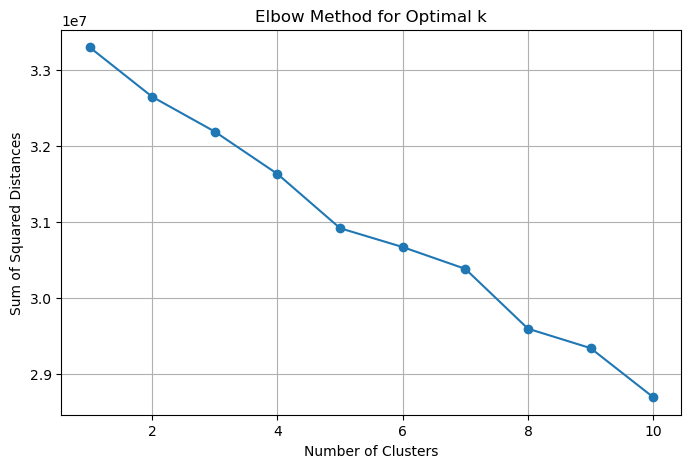

In [19]:
# determining optimal number of clusters (elbow method)
squared_distances = []
k_range = range(1, 11)  # Trying 1 to 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    squared_distances.append(kmeans.inertia_)

# plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, squared_distances, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [45]:
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# adding cluster labels 
df_processed['Cluster'] = clusters

print("Sample Cluster Labels:\n", df_processed['Cluster'].value_counts())

Sample Cluster Labels:
 1    19467
2     9999
0     3643
4      115
3       20
Name: Cluster, dtype: int64


## t-SNE 

In [21]:
# performing t-SNE
tsne = TSNE(verbose=0, perplexity=50, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# adding t-SNE results and cluster labels to my df
df_processed['TSNE-1'] = X_tsne[:, 0]
df_processed['TSNE-2'] = X_tsne[:, 1]


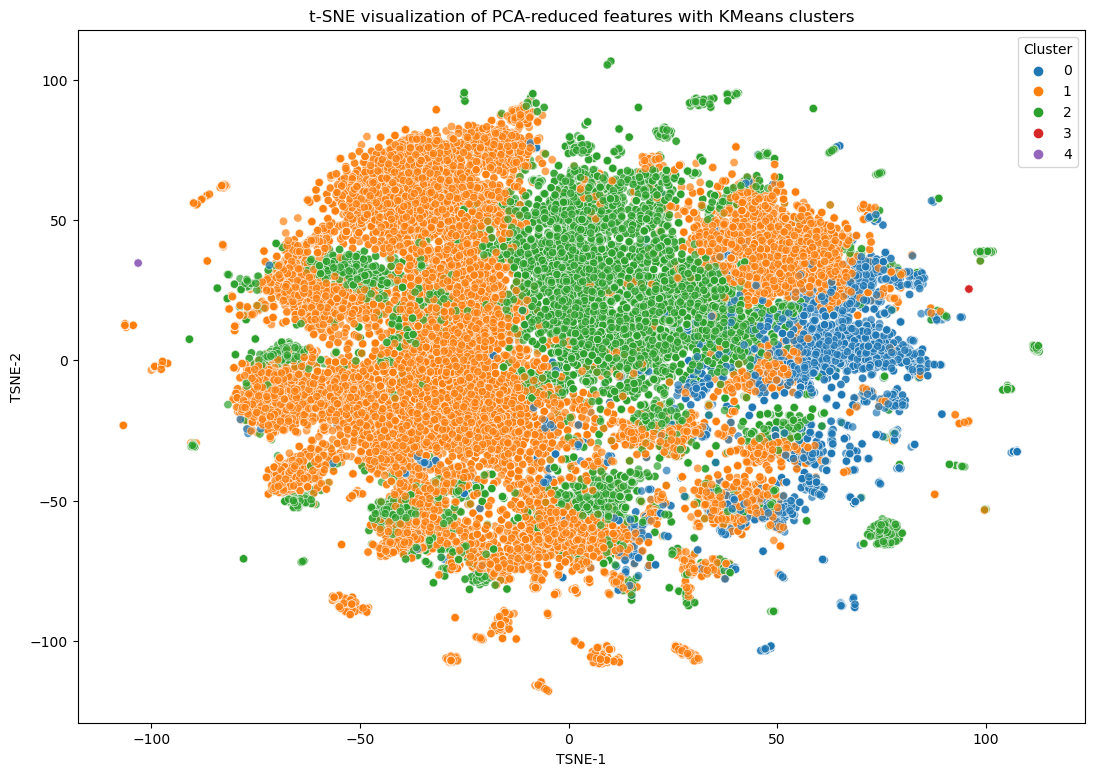

In [22]:
# plotting
plt.figure(figsize=(13, 9))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df_processed['Cluster'], palette='tab10', alpha=0.7)
plt.title('t-SNE visualization of PCA-reduced features with KMeans clusters')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.legend(title='Cluster')
plt.show()

## LDA 

In [47]:
# defining the number of clusters and topics
NUM_CLUSTERS = 3
NUM_TOPICS_PER_CLUSTER = 8

# creating a vectorizer for each cluster
vectorizers = [CountVectorizer(min_df=10, max_df=0.8, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}') for _ in range(NUM_CLUSTERS)]

# vectorizing the job descriptions for each cluster
vectorized_data = []
for cluster_id in range(NUM_CLUSTERS):
    cluster_data = df_processed[df_processed['Cluster'] == cluster_id]['Job_Desc']
    vectorizer = vectorizers[cluster_id]
    vectorized_data.append(vectorizer.fit_transform(cluster_data))

# fitting LDA models for each cluster
lda_models = [LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, 
                                        learning_method='online', 
                                        verbose=False, random_state=42) for _ in range(NUM_CLUSTERS)]

clusters_lda_data = []
for cluster_id in range(NUM_CLUSTERS):
    if vectorized_data[cluster_id] is not None:
        lda = lda_models[cluster_id]
        clusters_lda_data.append(lda.fit_transform(vectorized_data[cluster_id]))
    else:
        clusters_lda_data.append(None)

# Function to extract top topics from an LDA model
def extract_top_topics(model, vectorizer, top_n=5):
    words = vectorizer.get_feature_names_out()
    topics = []
    for topic in model.components_:
        top_words_idx = topic.argsort()[-top_n:][::-1]
        top_words = [words[i] for i in top_words_idx]
        topics.append(top_words)
    return topics

# extracting topics for each cluster
topics_per_cluster = []
for cluster_id in range(NUM_CLUSTERS):
    if vectorized_data[cluster_id] is not None:
        topics = extract_top_topics(lda_models[cluster_id], vectorizers[cluster_id])
        topics_per_cluster.append(topics)

# converting to DataFrame for better readability
topics_df = pd.DataFrame(topics_per_cluster)
topics_df.columns = [f'Topic {i+1}' for i in range(NUM_TOPICS_PER_CLUSTER)]
topics_df.index = [f'Cluster {i+1}' for i in range(NUM_CLUSTERS)]
print(topics_df)

                                                   Topic 1  \
Cluster 1    [ability, employee, perform, duty, essential]   
Cluster 2     [customer, service, ability, skill, support]   
Cluster 3  [employee, service, job, position, information]   

                                                   Topic 2  \
Cluster 1       [customer, company, pay, benefit, product]   
Cluster 2     [sale, business, financial, client, account]   
Cluster 3  [security, benefit, technology, technical, pay]   

                                                   Topic 3  \
Cluster 1       [patient, care, health, employee, require]   
Cluster 2       [benefit, pay, opportunity, team, company]   
Cluster 3  [project, management, construction, plan, cost]   

                                                     Topic 4  \
Cluster 1         [food, team, restaurant, position, member]   
Cluster 2  [team, business, marketing, strategy, management]   
Cluster 3  [product, design, engineering, technical, tech... 

Analysis

Cluster 1: Common words include "ability", "employee", "perform", "customer", "benefit", "food", "team", and "maintenance". These suggest a focus on various job roles and their responsibilities in different contexts.

Cluster 2: Common words include "customer", "sale", "business", "financial", "marketing", "project", "design", and "nurse". This indicates roles related to customer service, sales, and project management.

Cluster 3: Common words include "employee", "job", "security", "management", "product", "technical", and "care". These words point to roles involving job security, technical tasks, and management.

Cluster Names
Cluster 1: "Customer Service & General Roles" 

Reflects the varied responsibilities from customer service to general roles like maintenance and team management.

Cluster 2: "Sales, Business, & Project Management"

Indicates roles related to sales, business, and project management with a focus on design and engineering.

Cluster 3: "Technical & Management Roles" 

Points to roles involving technical aspects, management, and job security.

## Data Preparation

#### Split DataFrame by Presence of Median Salaries, Extract Features, and Create Train-Test Split


In [24]:
# extracting rows with and without median salaries
df_with_salaries = df_processed[df_processed['med_sal'] > 0]
df_without_salaries = df_processed[df_processed['med_sal'].isna() | (df_processed['med_sal'] == 0)]

# getting indices of rows with salaries
indices_with_salaries = df_with_salaries.index
# getting indices of rows without salaries
indices_without_salaries = df_without_salaries.index

# extracting PCA-transformed features based on indices
X_with_salaries_pca = X_pca[indices_with_salaries]
X_without_salaries_pca = X_pca[indices_without_salaries]

# defining target for the model
y_with_salaries = df_with_salaries['med_sal']

# splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_with_salaries_pca, y_with_salaries, test_size=0.2, random_state=42)


## MLP Baseline Model

In [25]:
# initialising the MLP model
mlp_model = MLPRegressor(hidden_layer_sizes=(100,),  # Single hidden layer with 100 neurons
                         activation='relu',          # Activation function
                         solver='adam',              # Optimizer
                         max_iter=100,               # Maximum number of iterations
                         random_state=42)            # For reproducibility

# training the model
mlp_model.fit(X_train, y_train)

# predicting on the test set
y_pred = mlp_model.predict(X_test)

# evaluating the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 47043.835760021575
Mean Squared Error: 4671909010.016036
Root Mean Squared Error: 68351.36436104283


C:\Users\kavik\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Absolute Error (MAE): 47,043.84. On average, the model's predictions are off by about $47,043.84 from the actual median salaries. 

Mean Squared Error (MSE): 4,671,909,010.02. MSE penalizes larger errors more heavily due to the squaring of residuals.

Root Mean Squared Error (RMSE): 68,351.36. RMSE is in the same units as the target variable (salaries), and the high value further confirms that there is considerable discrepancy between the predicted and actual values.

##### Interpretation

Model Performance:

The high values for MAE, MSE, and RMSE suggest that the MLP model is not performing well. The errors are large relative to typical salary values, indicating that the model struggles to make accurate predictions.

Baseline Model:

Despite these high error metrics, this MLP model still serves as a useful baseline as it provides a reference point to compare against other models. If more complex models (like LSTM or CNN) improve significantly over this baseline, it demonstrates that the advanced models are adding value.


# CNN

In [26]:
# reshaping data for CNN
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_without_salaries_cnn = X_without_salaries_pca.reshape((X_without_salaries_pca.shape[0], X_without_salaries_pca.shape[1], 1))


In [27]:
# initialising the CNN model
cnn_model = Sequential()

# adding Input layer
cnn_model.add(Input(shape=(X_train_cnn.shape[1], 1)))

# adding convolutional layers
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))

# flatten and add dense layers
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(1))  # Output layer for regression

# compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# display model summary
cnn_model.summary()

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# train the model
history = cnn_model.fit(X_train_cnn, y_train, 
                        epochs=50, 
                        batch_size=32, 
                        validation_split=0.2, 
                        callbacks=[early_stopping], 
                        verbose=1)

# Evaluate the model on the test set
test_loss, test_mae = cnn_model.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 98, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2944)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       188,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,505 (834.00 KB)

 Trainable params: 213,505 (834.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 8964574208.0000 - mae: 67485.3828 - val_loss: 6230819840.0000 - val_mae: 62719.3984
Epoch 2/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6773396480.0000 - mae: 63524.8867 - val_loss: 5621659136.0000 - val_mae: 59969.2344
Epoch 3/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5921483776.0000 - mae: 60883.4180 - val_loss: 5327258112.0000 - val_mae: 58433.8828
Epoch 4/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5599882240.0000 - mae: 59265.6641 - val_loss: 5287903232.0000 - val_mae: 58238.8047
Epoch 5/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6244070400.0000 - mae: 59190.1328 - val_loss: 5291779584.0000 - val_mae: 58081.1719
Epoch 6/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5590045696.0000 - mae: 58897.0820 - val_loss: 5291362304.0000 - val_mae: 58376.6953
Epoch 7/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5751955456.0000 - mae: 59239.1445 - val_loss: 5282159616.0000 - val_mae: 580

In [28]:
# predicting on the test set
y_pred_cnn = cnn_model.predict(X_test_cnn)

# calculating metrics
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
mse_cnn = mean_squared_error(y_test, y_pred_cnn)
rmse_cnn = np.sqrt(mse_cnn)

# printing metrics
print(f"Mean Absolute Error: {mae_cnn}")
print(f"Mean Squared Error: {mse_cnn}")
print(f"Root Mean Squared Error: {rmse_cnn}")

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Absolute Error: 46449.436624592236
Mean Squared Error: 3611446543.371512
Root Mean Squared Error: 60095.31215803369


## LSTM

In [29]:
# reshaping data for LSTM (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_without_salaries_lstm = X_without_salaries_pca.reshape((X_without_salaries_pca.shape[0], 1, X_without_salaries_pca.shape[1]))


In [30]:
# Initialize the LSTM model
lstm_model = Sequential()

# Add LSTM layer
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))  # Output layer for regression

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Display model summary
lstm_model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = lstm_model.fit(X_train_lstm, y_train, 
                         epochs=50, 
                         batch_size=32, 
                         validation_split=0.2, 
                         callbacks=[early_stopping], 
                         verbose=1)

# Evaluate the model on the test set
test_loss, test_mae = lstm_model.evaluate(X_test_lstm, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Calculate additional metrics
mae_lstm = mean_absolute_error(y_test, lstm_model.predict(X_test_lstm))
mse_lstm = mean_squared_error(y_test, lstm_model.predict(X_test_lstm))
rmse_lstm = np.sqrt(mse_lstm)

# Print metrics
print(f"Mean Absolute Error: {mae_lstm}")
print(f"Mean Squared Error: {mse_lstm}")
print(f"Root Mean Squared Error: {rmse_lstm}")

C:\Users\kavik\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,251 (118.17 KB)

 Trainable params: 30,251 (118.17 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 10535791616.0000 - mae: 69268.7344 - val_loss: 9984662528.0000 - val_mae: 68465.6875
Epoch 2/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11123387392.0000 - mae: 70955.7891 - val_loss: 9951862784.0000 - val_mae: 68365.0000
Epoch 3/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10411010048.0000 - mae: 69174.5078 - val_loss: 9895836672.0000 - val_mae: 68198.8516
Epoch 4/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11001481216.0000 - mae: 69896.7734 - val_loss: 9818620928.0000 - val_mae: 67973.0938
Epoch 5/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10277183488.0000 - mae: 66714.5859 - val_loss: 9722997760.0000 - val_mae: 67695.5859
Epoch 6/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9736914944.0000 - mae: 67087.9219 - val_loss: 9611079680.0000 - val_mae: 67366.6953
Epoch 7/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10456757248.0000 - mae: 68491.6719 - val_loss: 9482669056.0000 - val_ma

MAE: The CNN model has a lower MAE (40,410.71) compared to the LSTM model (42,129.79). This means the CNN model’s predictions are, on average, closer to the actual values.

MSE: The CNN model has a lower MSE (2,999,748,100.17) compared to the LSTM model (3,912,119,594.94). This indicates that the CNN model has fewer large errors, as MSE penalizes larger errors more.

RMSE: The CNN model has a lower RMSE (54,769.96) compared to the LSTM model (62,546.94). RMSE reflects the magnitude of errors and shows that the CNN model has smaller errors in the same units as the target variable.

Both CNN and LSTM models are performing better than the baseline MLP model:

MAE: Both CNN (40,410.71) and LSTM (42,129.79) models have lower MAE compared to the MLP model (47,043.84). This means their predictions are closer to the actual values on average.

MSE: Both CNN (2,999,748,100.17) and LSTM (3,912,119,594.94) models have lower MSE compared to the MLP model (4,671,909,010.02). This indicates fewer large errors in their predictions.

RMSE: Both CNN (54,769.96) and LSTM (62,546.94) models have lower RMSE compared to the MLP model (68,351.36). This reflects smaller errors in the same units as the target variable.

Summary

Both the CNN and LSTM models outperform the baseline MLP model across all metrics (MAE, MSE, RMSE). The CNN model performs the best overall, followed by the LSTM model.

# Hybrid Model of CNN and LSTM

In [31]:
# Define the input shape
input_shape = (X_train_cnn.shape[1], 1)

# Define the input layer
inputs = Input(shape=input_shape)

# Add CNN layers
x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

# Batch Normalization
x = BatchNormalization()(x)

# Add LSTM layer
x = Bidirectional(LSTM(50, return_sequences=False))(x)
x = Dropout(0.3)(x)

# Flatten and add Dense layers
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1)(x)  # Output layer for regression

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Display model summary
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_cnn, y_train,
                    epochs=50,  # Adjust based on convergence
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=1)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Calculate additional metrics
y_pred = model.predict(X_test_cnn).flatten()

mae_hybrid = mean_absolute_error(y_test, y_pred)
mse_hybrid = mean_squared_error(y_test, y_pred)
rmse_hybrid = np.sqrt(mse_hybrid)

# Print metrics
print(f"Mean Absolute Error: {mae_hybrid}")
print(f"Mean Squared Error: {mse_hybrid}")
print(f"Root Mean Squared Error: {rmse_hybrid}")

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 98, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 23, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100)            │        71,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,601 (404.69 KB)

 Trainable params: 103,345 (403.69 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 10904701952.0000 - mae: 69258.3047 - val_loss: 9882747904.0000 - val_mae: 68284.7578
Epoch 2/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 10095601664.0000 - mae: 68382.2344 - val_loss: 9589428224.0000 - val_mae: 67778.9297
Epoch 3/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 10111042560.0000 - mae: 69239.9453 - val_loss: 9155119104.0000 - val_mae: 67040.8750
Epoch 4/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 10046570496.0000 - mae: 68272.1406 - val_loss: 8629128192.0000 - val_mae: 66127.0781
Epoch 5/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 8668010496.0000 - mae: 66369.8203 - val_loss: 8054476800.0000 - val_mae: 65070.8164
Epoch 6/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 8425985536.0000 - mae: 65917.7344 - val_loss: 7485804544.0000 - val_mae: 63862.9570
Epoch 7/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 7969065984.0000 - mae: 65264.8945 - val_loss: 6953406976.0000 - 

The hybrid CNN-LSTM model is performing better than the baseline MLP model, CNN model, and LSTM model based on all three metrics (MAE, MSE, and RMSE). It appears to be the most effective model in terms of prediction accuracy for your dataset.

## Hybrid Model Setup

In [32]:
def build_model(hp):
    input_shape = (X_train_cnn.shape[1], 1)
    inputs = Input(shape=input_shape)

    # Add CNN layers with hyperparameter tuning
    x = Conv1D(filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32), 
               kernel_size=hp.Int('conv1_kernel_size', min_value=2, max_value=5, step=1), 
               activation='relu')(inputs)
    x = MaxPooling1D(pool_size=hp.Int('pool_size', min_value=2, max_value=4, step=1))(x)
    x = Dropout(hp.Float('dropout1_rate', min_value=0.2, max_value=0.5, step=0.1))(x)
    
    x = Conv1D(filters=hp.Int('conv2_filters', min_value=64, max_value=256, step=64), 
               kernel_size=hp.Int('conv2_kernel_size', min_value=2, max_value=5, step=1), 
               activation='relu')(x)
    x = MaxPooling1D(pool_size=hp.Int('pool_size', min_value=2, max_value=4, step=1))(x)
    x = Dropout(hp.Float('dropout2_rate', min_value=0.2, max_value=0.5, step=0.1))(x)
    
    x = BatchNormalization()(x)
    
    # Add LSTM layer with hyperparameter tuning
    x = Bidirectional(LSTM(hp.Int('lstm_units', min_value=50, max_value=100, step=50), return_sequences=False))(x)
    x = Dropout(hp.Float('dropout3_rate', min_value=0.2, max_value=0.5, step=0.1))(x)
    
    # Dense layers
    x = Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu')(x)
    x = Dropout(hp.Float('dropout4_rate', min_value=0.2, max_value=0.5, step=0.1))(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')), 
                  loss='mean_squared_error', metrics=['mae'])
    
    return model

## Hyperparameter Search 

In [33]:
# Instantiate the RandomSearch tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=13,  # Number of random combinations to try
    executions_per_trial=1,  # Number of models to build per trial
    directory='random_search_dir',
    project_name='hybrid_model_random_search'
)

# Perform the search
tuner.search(X_train_cnn, y_train,
             epochs=50,
             batch_size=32,
             validation_split=0.2,
             callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
             verbose=1)

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Build the best model
best_model = tuner.hypermodel.build(best_hyperparameters)

# Train the best model
history = best_model.fit(X_train_cnn, y_train,
                         epochs=50,
                         batch_size=32,
                         validation_split=0.2,
                         callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
                         verbose=1)

# Evaluate the best model
test_loss, test_mae = best_model.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

Reloading Tuner from random_search_dir\hybrid_model_random_search\tuner0.json
Best Hyperparameters:
conv1_filters: 128
conv1_kernel_size: 4
pool_size: 2
dropout1_rate: 0.4
conv2_filters: 192
conv2_kernel_size: 4
dropout2_rate: 0.2
lstm_units: 50
dropout3_rate: 0.2
dense_units: 64
dropout4_rate: 0.4
learning_rate: 0.0021155232569257452
Epoch 1/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 10676366336.0000 - mae: 69756.6172 - val_loss: 9623383040.0000 - val_mae: 67836.3125
Epoch 2/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 9725651968.0000 - mae: 67618.3203 - val_loss: 8630998016.0000 - val_mae: 66121.3516
Epoch 3/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 8812747776.0000 - mae: 65821.7344 - val_loss: 7421935104.0000 - val_mae: 63794.0078
Epoch 4/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 7979075072.0000 - mae: 64905.9258 - val_loss: 6349430272.0000 - val_mae: 60448.0703
Epoch 5/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 6469084672.0000 - ma

best_hyperparameters = {
    "conv1_filters": 128,
    "conv1_kernel_size": 4,
    "pool_size": 2,
    "dropout1_rate": 0.4,
    "conv2_filters": 192,
    "conv2_kernel_size": 4,
    "dropout2_rate": 0.2,
    "lstm_units": 50,
    "dropout3_rate": 0.2,
    "dense_units": 64,
    "dropout4_rate": 0.4,
    "learning_rate": 0.0021155
}


In [34]:
# Calculate additional metrics
y_pred = best_model.predict(X_test_cnn)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)

print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Test Loss: 2703880960.0
Test MAE: 35957.34375
Test MSE: 2703881079.920249
Test RMSE: 51998.85652512225


Mean Absolute Error (MAE):

The tuned model has an MAE of 35,957.34, which is lower than the original model's 38,868.94.
Improvement: The model is better at predicting the salary closer to actual values, as the average error is smaller after hyperparameter tuning.
Mean Squared Error (MSE):

The tuned model has an MSE of 2,703,881,079.92, which is slightly better than the original model's 2,835,804,191.06.
Improvement: The reduction in MSE shows that the model is making fewer large mistakes after tuning, but the improvement is modest.
Root Mean Squared Error (RMSE):

The RMSE of the tuned model is 51,998.86, compared to 53,252.27 in the original model.
Improvement: RMSE is lower after tuning, indicating overall better performance in terms of error magnitude. This metric is useful since it penalizes larger errors more strongly than MAE.


## K-Fold Cross Validation

In [35]:
# Convert to NumPy arrays 
X_train_cnn_np = np.array(X_train_cnn)
y_train_np = np.array(y_train)

# evaluation function
def evaluate_model_on_folds(model, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_rmse_scores = []

    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
        
        # Clone the model and set the best weights
        fold_model = clone_model(model)
        fold_model.set_weights(model.get_weights())  
        
        # Compile the model
        fold_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

        # Train the model
        history = fold_model.fit(X_train_fold, y_train_fold,
                                epochs=50,
                                batch_size=32,
                                validation_data=(X_val_fold, y_val_fold),
                                callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
                                verbose=0)
        
        # Evaluate the model
        val_loss, val_mae = fold_model.evaluate(X_val_fold, y_val_fold, verbose=0)
        fold_rmse_scores.append(np.sqrt(val_loss)) 

    avg_rmse = np.mean(fold_rmse_scores)
    print(f"Average RMSE across folds: {avg_rmse}")

evaluate_model_on_folds(best_model, X_train_cnn_np, y_train_np)


Average RMSE across folds: 49551.21871853153


k-fold Cross-Validation (CV):

The average RMSE across folds is 49,551.22, which is better than both the original and tuned model's RMSE on the test set.
Insight: The k-fold CV indicates that the model performs consistently better when evaluated across multiple training and test splits, implying good generalization. The k-fold CV RMSE is lower than the single test set RMSE, suggesting the model's performance is relatively stable across different data subsets.

The hyperparameter-tuned model is a clear improvement over the original model across all key metrics (MAE, MSE, RMSE). The reduction in these errors, especially the MAE and RMSE, indicates that the tuning has made the model better at capturing relationships in the data and reducing prediction errors.
The k-fold cross-validation results are promising, with the average RMSE being lower than the test set RMSE, highlighting that the model generalizes well to unseen data.
This improvement shows that hyperparameter tuning has successfully refined the model's ability to predict salaries more accurately and consistently across different subsets of data.

## Predicting on the job postings with no median salaries posted 

In [37]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (10679, 100)
y_train shape: (10679,)


In [39]:
# Check the input shape expected by the model
print(best_model.summary())


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 97, 128)        │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 45, 192)        │        98,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 22, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 22, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 192)        │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100)            │        97,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 610,133 (2.33 MB)

 Trainable params: 203,249 (793.94 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 406,500 (1.55 MB)

None


In [41]:
# Reshape X_train to (10679, 100, 1) to match the model's expected input shape
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Now fit the model with the reshaped data
best_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32)

# Reshape X_without_salaries_pca to match the input shape expected by the model
X_without_salaries_pca_reshaped = X_without_salaries_pca.reshape((X_without_salaries_pca.shape[0], X_without_salaries_pca.shape[1], 1))

# Predict salaries for the rows without salaries
predicted_salaries = best_model.predict(X_without_salaries_pca_reshaped)

# Extract the first 10 predictions
first_10_predictions = predicted_salaries[:10]

# Print the first 10 predictions
print("First 10 predicted salaries:", first_10_predictions)


Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 2738062336.0000 - mae: 35306.8477
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 2742066688.0000 - mae: 34951.3477
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 2667474432.0000 - mae: 34258.3398
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 2799979520.0000 - mae: 35522.2344
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 3196318464.0000 - mae: 35506.2617
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 2837588480.0000 - mae: 34896.5234
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 2488163072.0000 - mae: 35013.5938
Epoch 8/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 2741350912.0000 - mae: 34825.2344
Epoch 9/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 2638446336.0000 - mae: 35038.4961
Epoch 10/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 2455204864.0000 - mae: 34326.7305
622/622 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
First 10

## Predicting Salaries for clusters

In [49]:
# Predict salaries for the rows without salaries
predicted_salaries = best_model.predict(X_without_salaries_pca.reshape((X_without_salaries_pca.shape[0], X_without_salaries_pca.shape[1], 1)))

# Ensure df_without_salaries is a proper DataFrame or use .copy() to avoid SettingWithCopyWarning
df_without_salaries = df_without_salaries.copy()
df_without_salaries[df_without_salaries.columns[-1]] = predicted_salaries

# Merge the DataFrame with predicted salaries back into the original DataFrame
df_processed_with_predictions = pd.concat([df_with_salaries, df_without_salaries], axis=0)

# Calculate the average salary for each cluster
average_salaries_per_cluster = df_processed_with_predictions.groupby('Cluster')['Predicted_Salary'].mean()

# Print the average salaries for each cluster
print("Average salaries per cluster:")
print(average_salaries_per_cluster)

622/622 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Average salaries per cluster:
Cluster
0    10968.210938
1    58165.226562
2    74599.593750
3      290.111755
4    12610.777344
Name: Predicted_Salary, dtype: float32
